# House Prices: Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

### Competition Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills
- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting

## 1. importing libraries&dataset

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_train = pd.read_csv("./train.csv", index_col="Id")
df_test = pd.read_csv("./test.csv", index_col="Id")

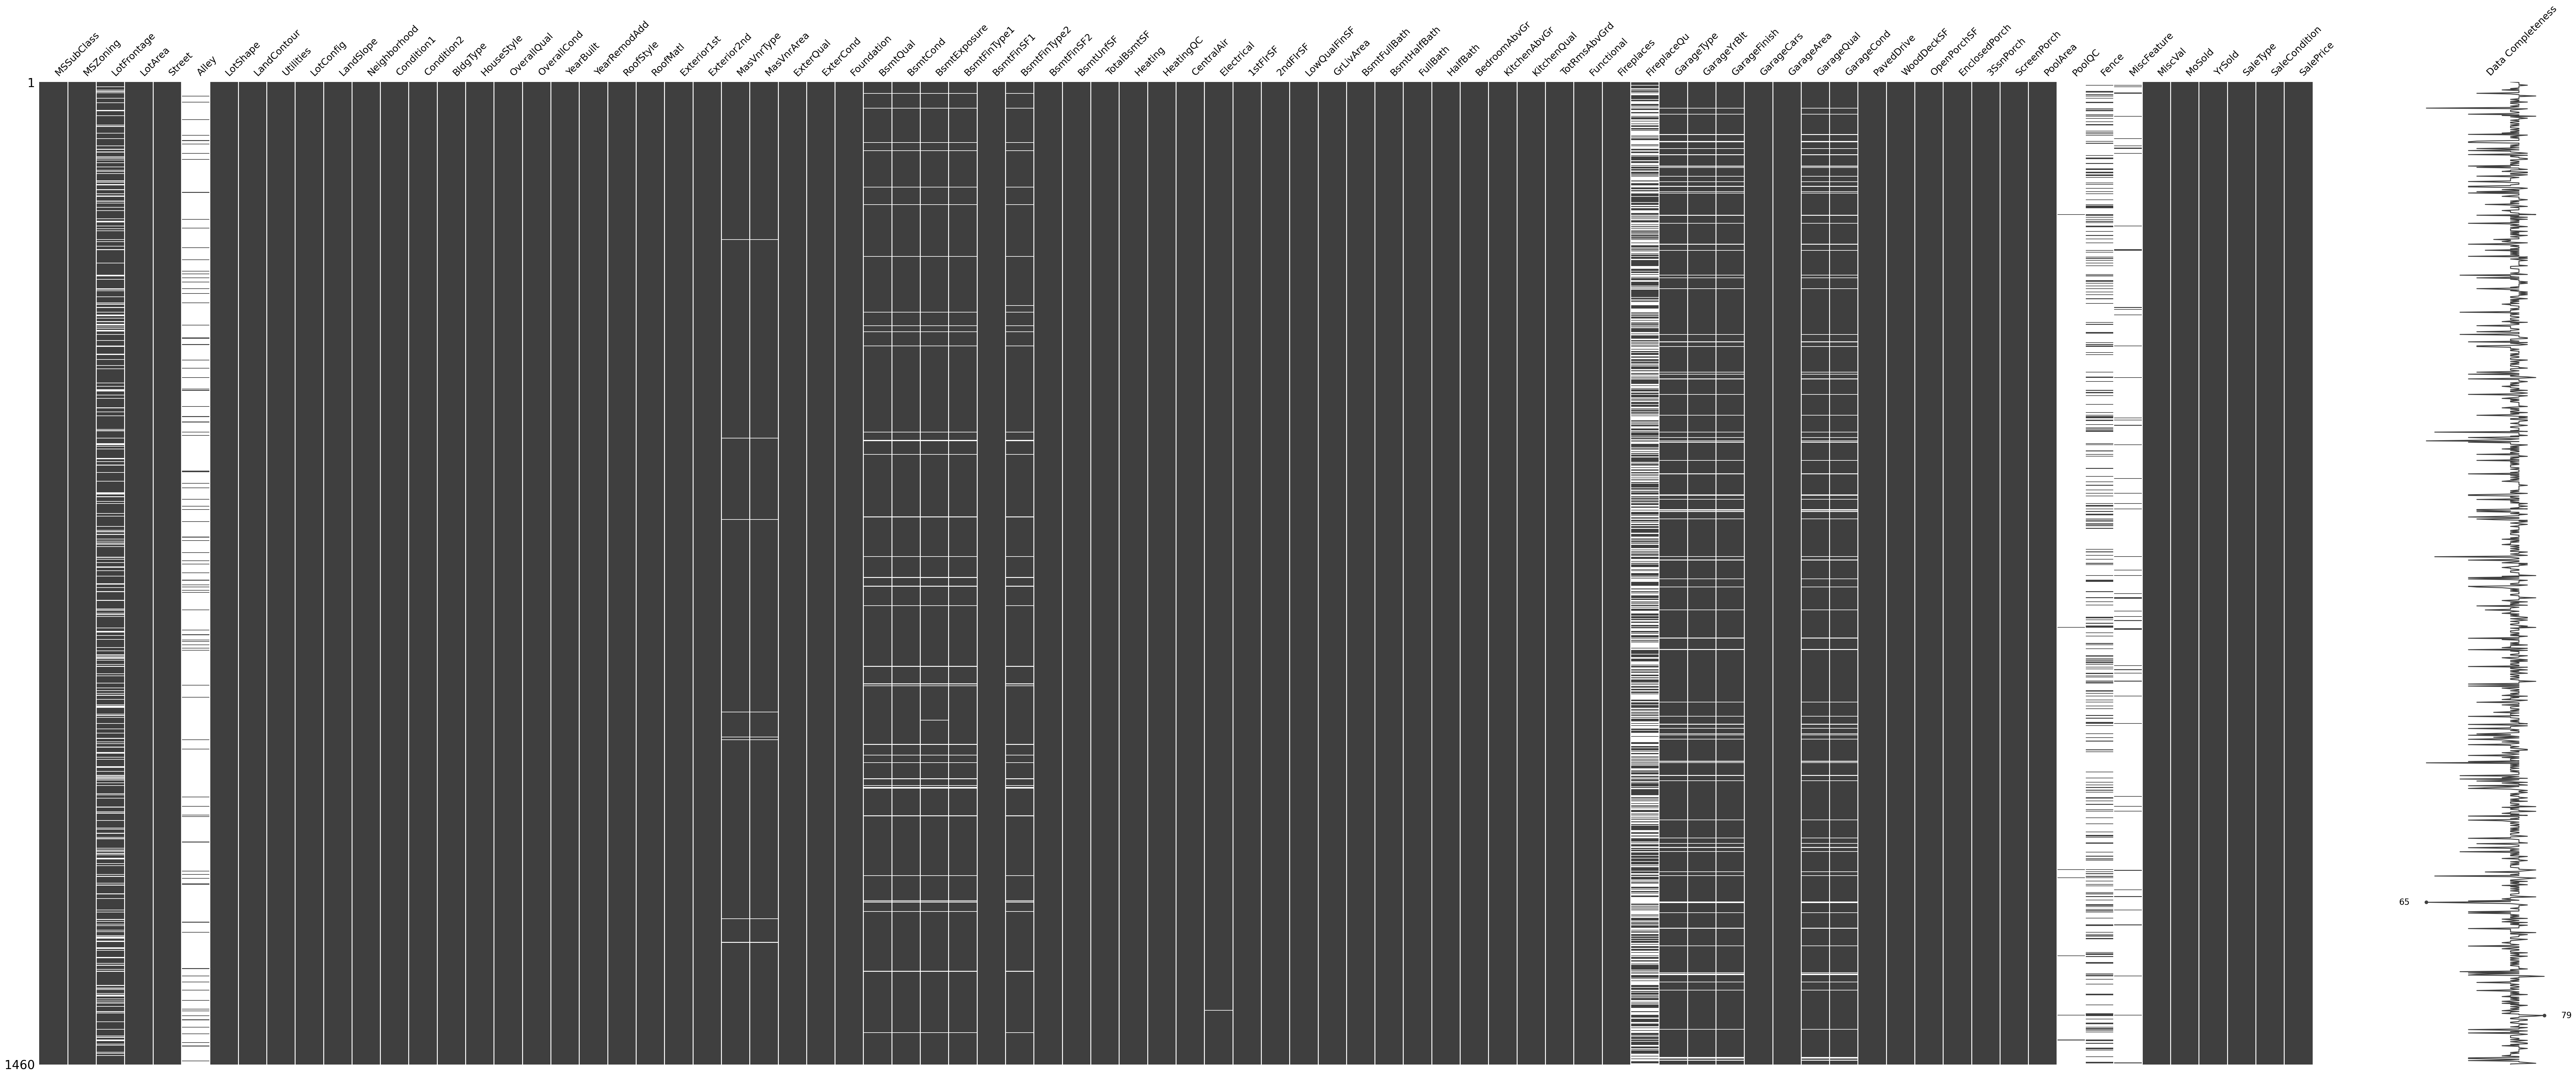

In [3]:
msno.matrix(df_train, figsize=(75, 30), labels=True) # so much null (white space)

## 2. Data Preprocessing (Feature Engineering)

In [4]:
df = pd.concat([df_train, df_test], axis=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [5]:
drop_col = ["Neighborhood", "BsmtFinSF2", "MiscFeature"]
val_col = ["LotFrontage", "MasVnrArea", "GarageYrBlt", "LotFrontage", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]
cat_col = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageFinish", 
           "GarageQual", "GarageCond", "MasVnrType", "FireplaceQu", "Alley"]
binary_col = ["PoolQC", "Fence"]
# Add: Alley, FireplaceQu

In [6]:
df = df.drop(columns=drop_col)

In [7]:
for i in val_col: 
    df[i].fillna(0, inplace=True)

In [8]:
for i in cat_col: 
    df[i] = df[i].fillna("No")

In [9]:
for i in binary_col: 
    df[i].fillna(0, inplace=True)
    df[i] = df[i].apply(lambda x: 0 if x == 0 else 1)

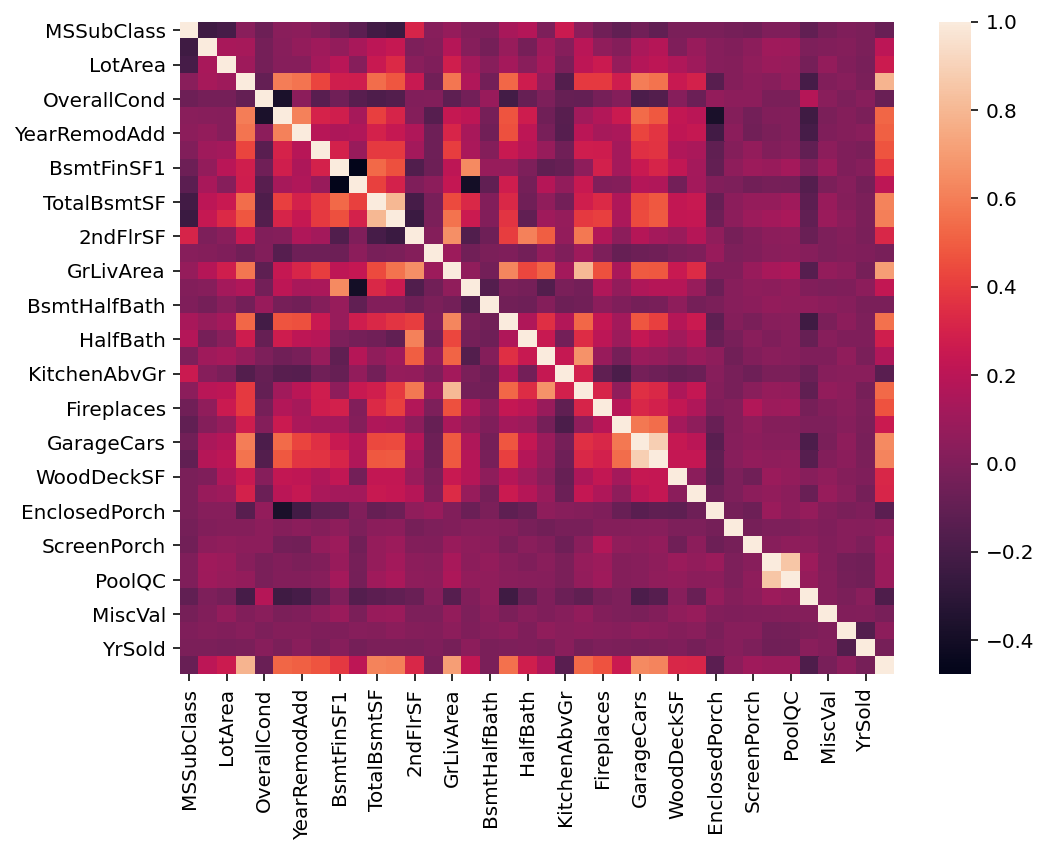

In [10]:
cor_df = df.select_dtypes(np.number).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cor_df)

## 3. Data Visualization & EDA

In [11]:
df = pd.get_dummies(df.iloc[:, df.columns != "SalePrice"])
X = df.iloc[:df_train.shape[0], :]
y = df_train["SalePrice"]
X_test = df.iloc[df_train.shape[0] :, :]

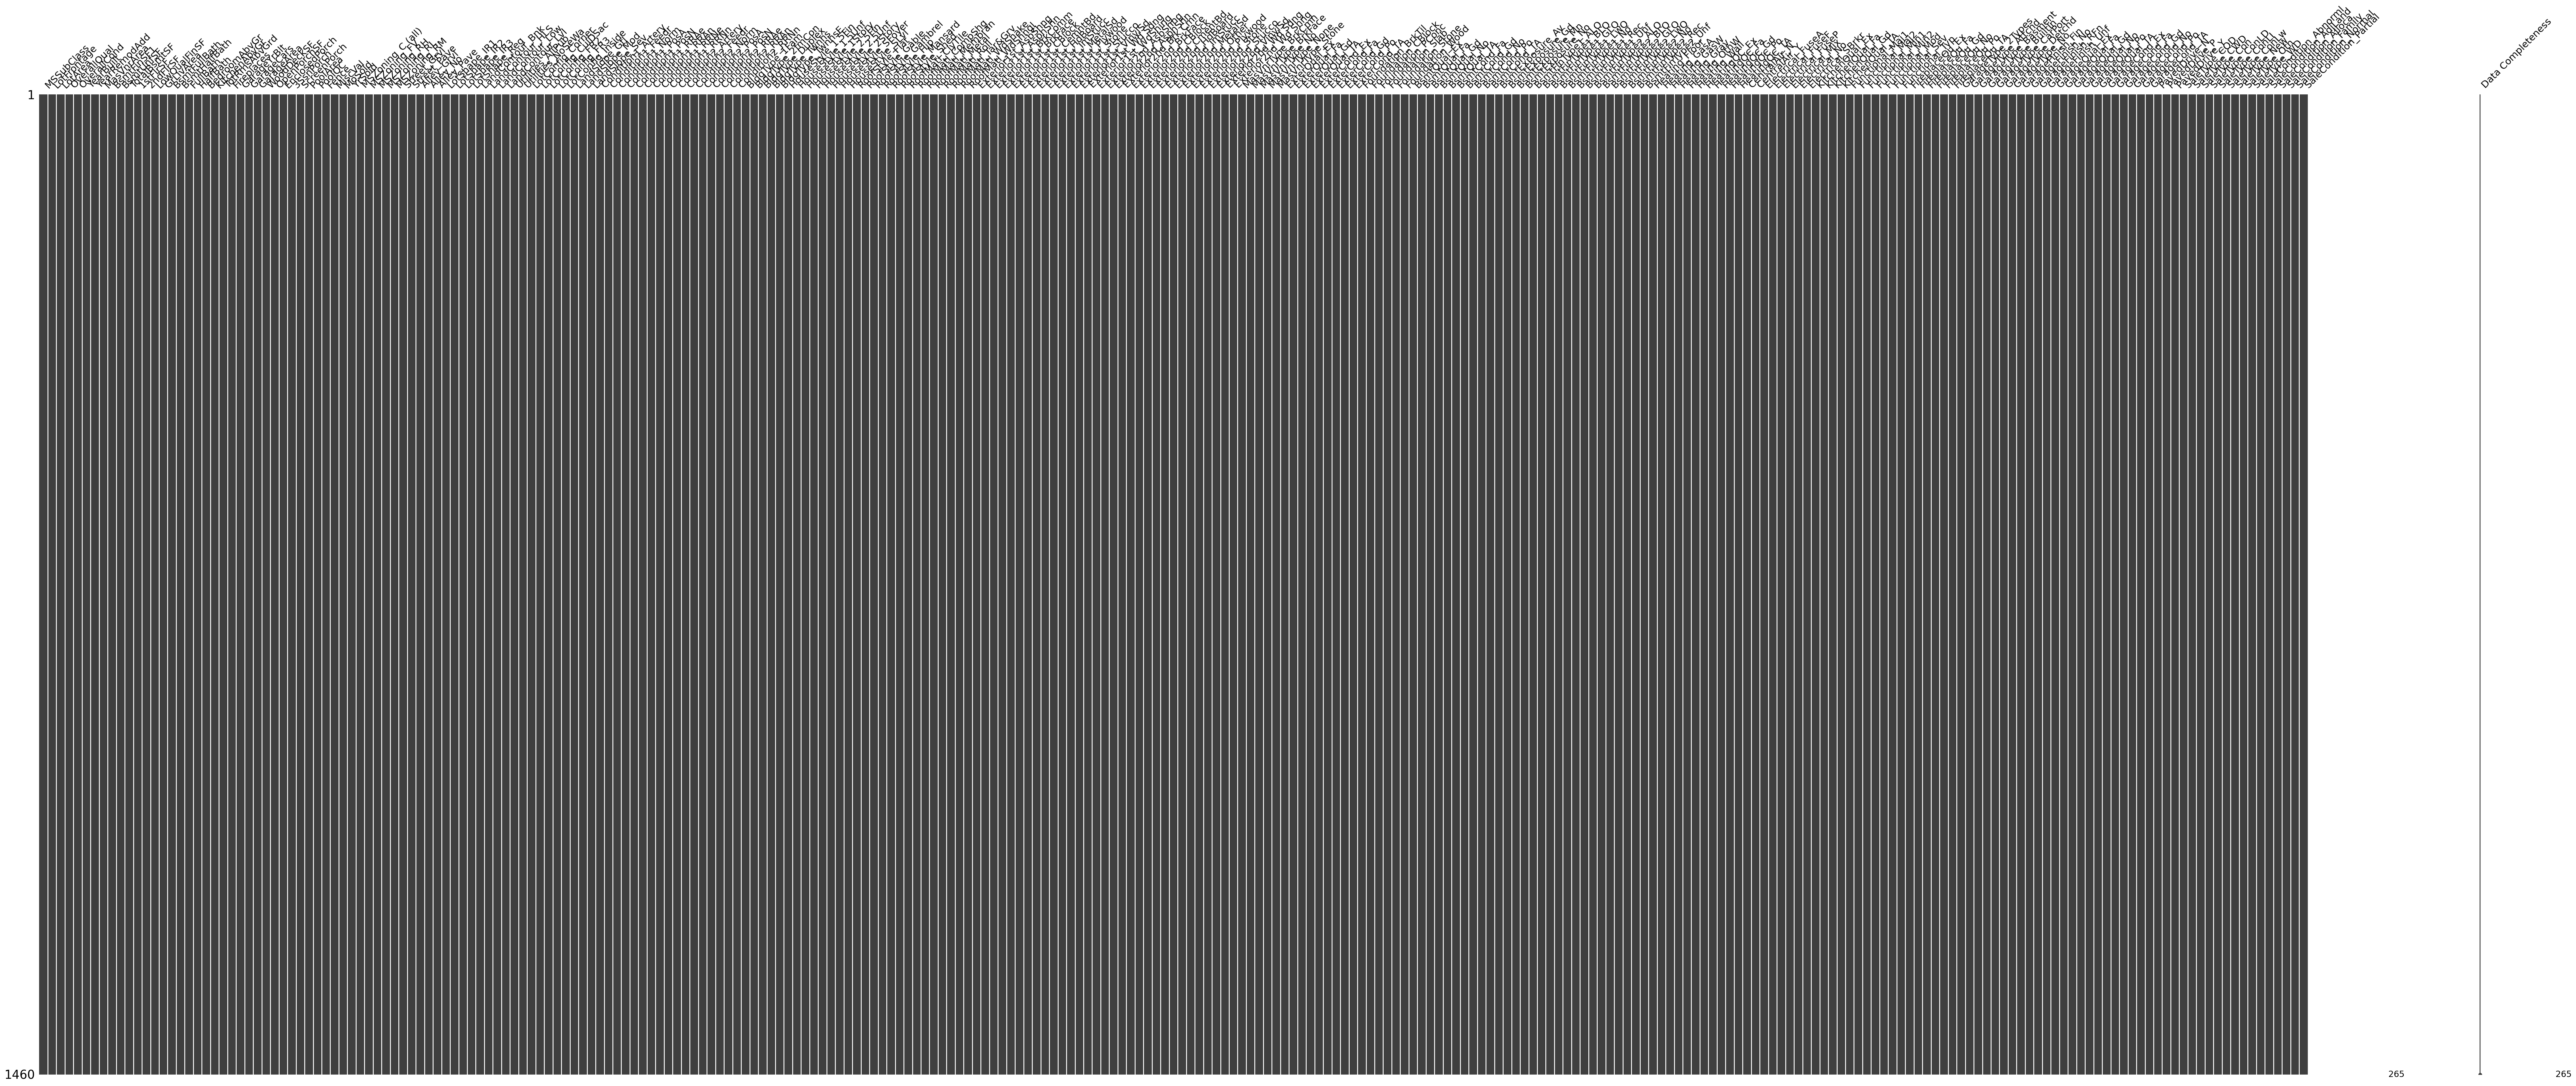

In [12]:
msno.matrix(X, figsize=(75, 30), labels=True) #NA checked

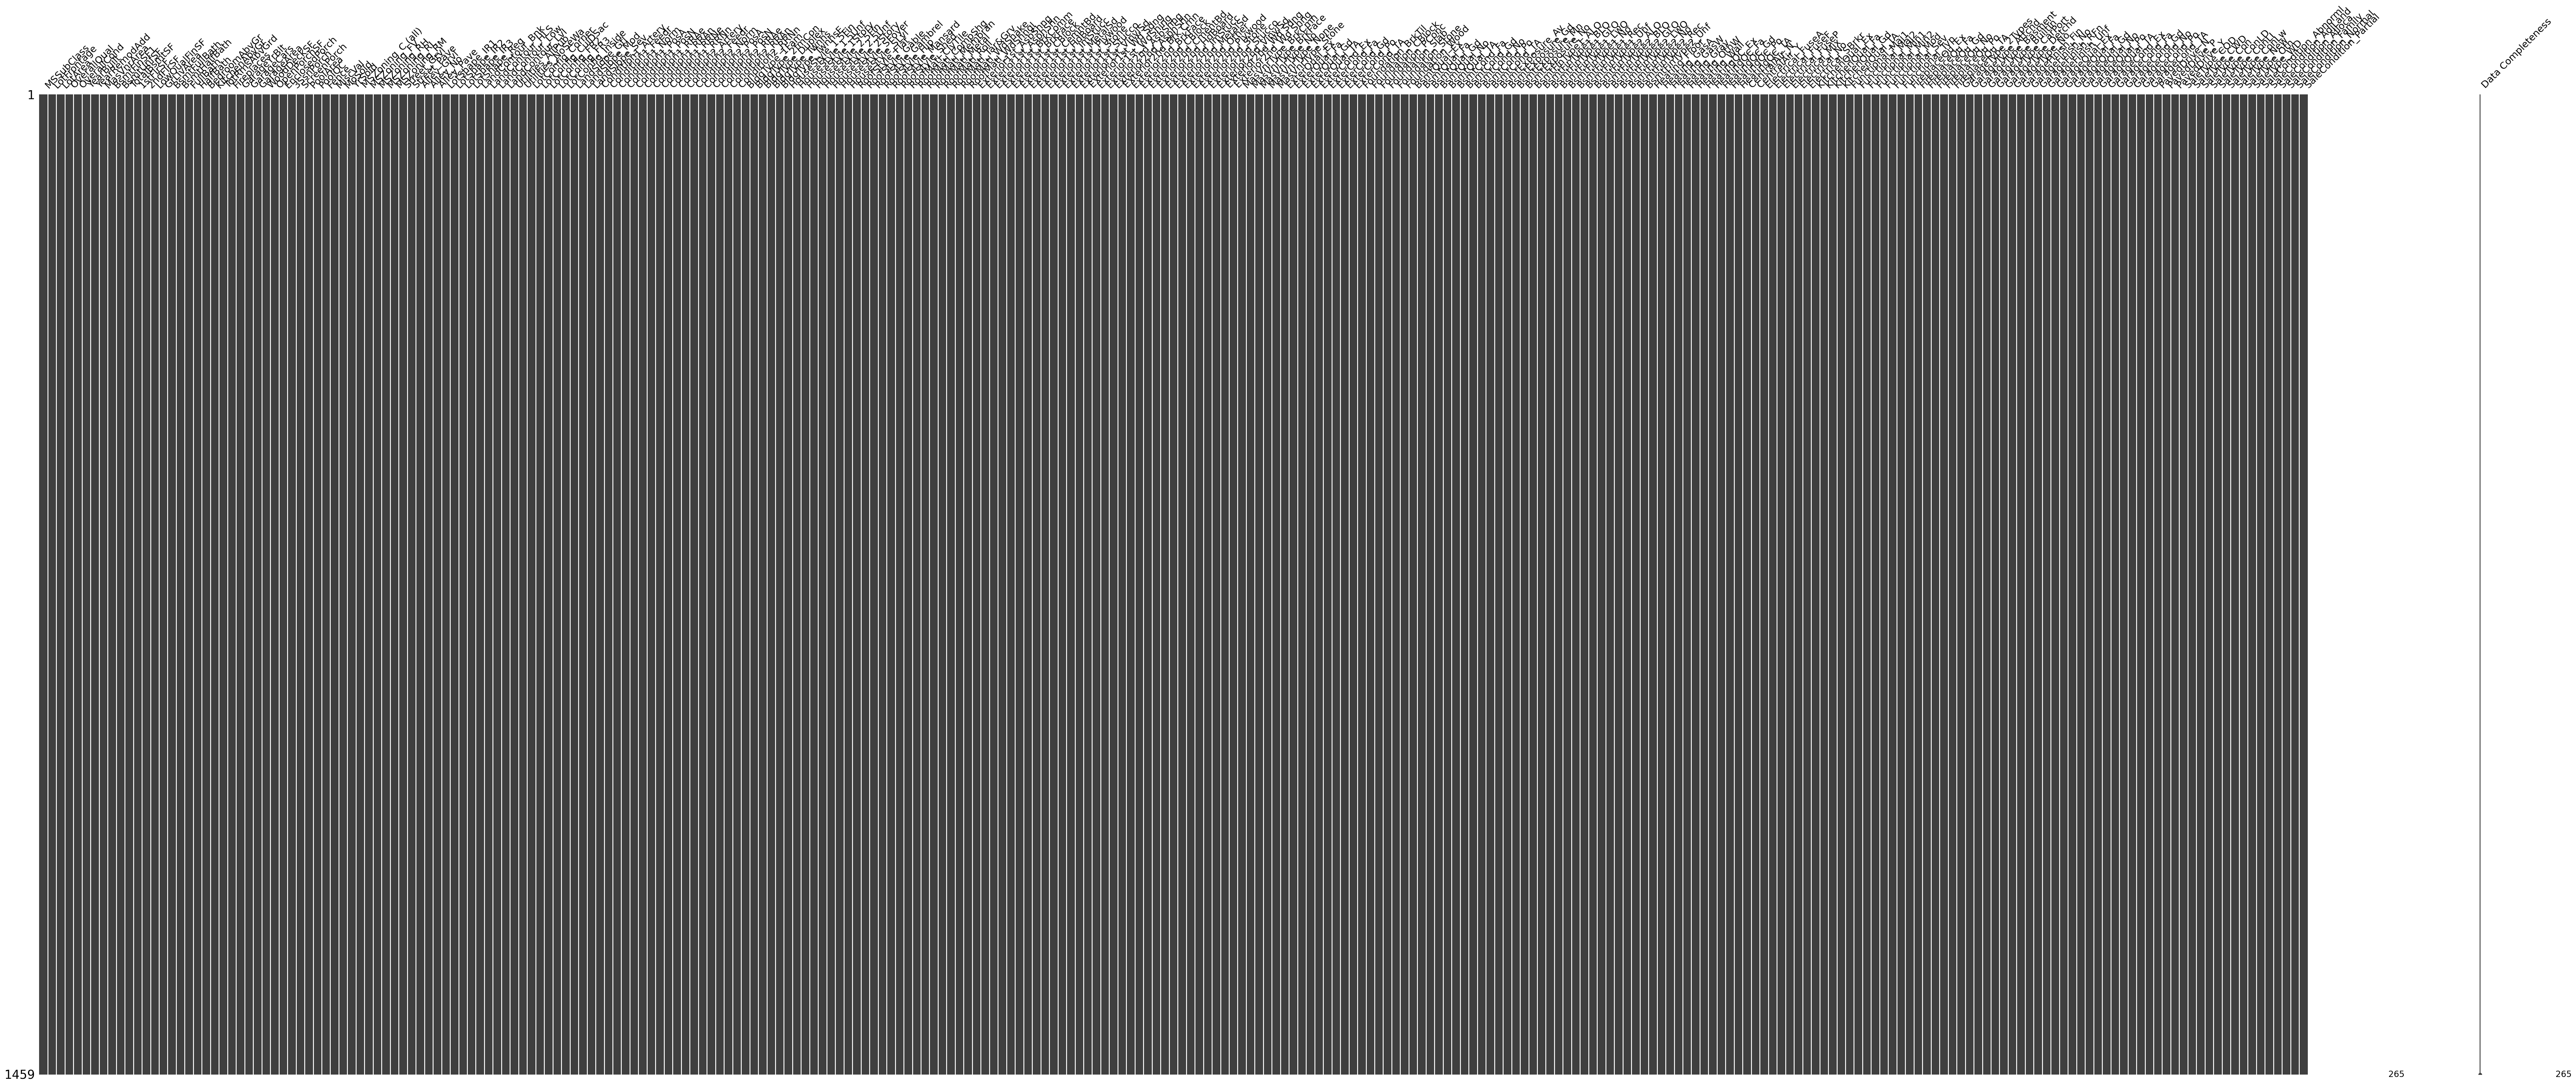

In [13]:
msno.matrix(X_test, figsize=(75, 30), labels=True)

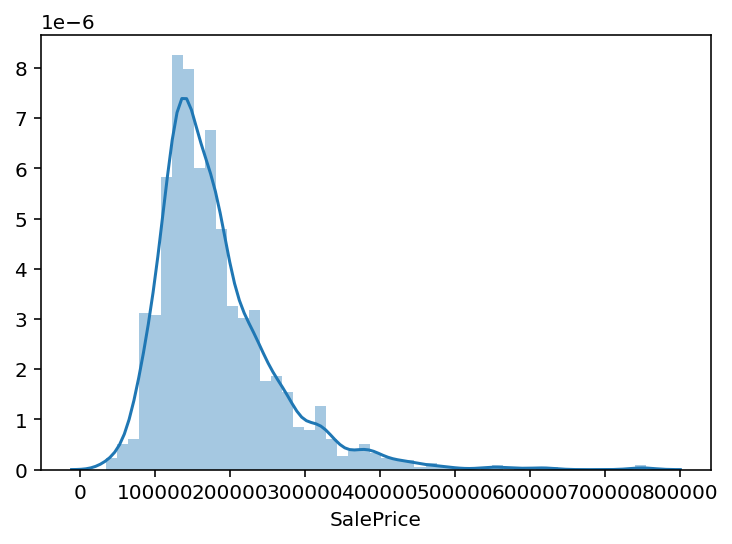

In [14]:
sns.distplot(y)

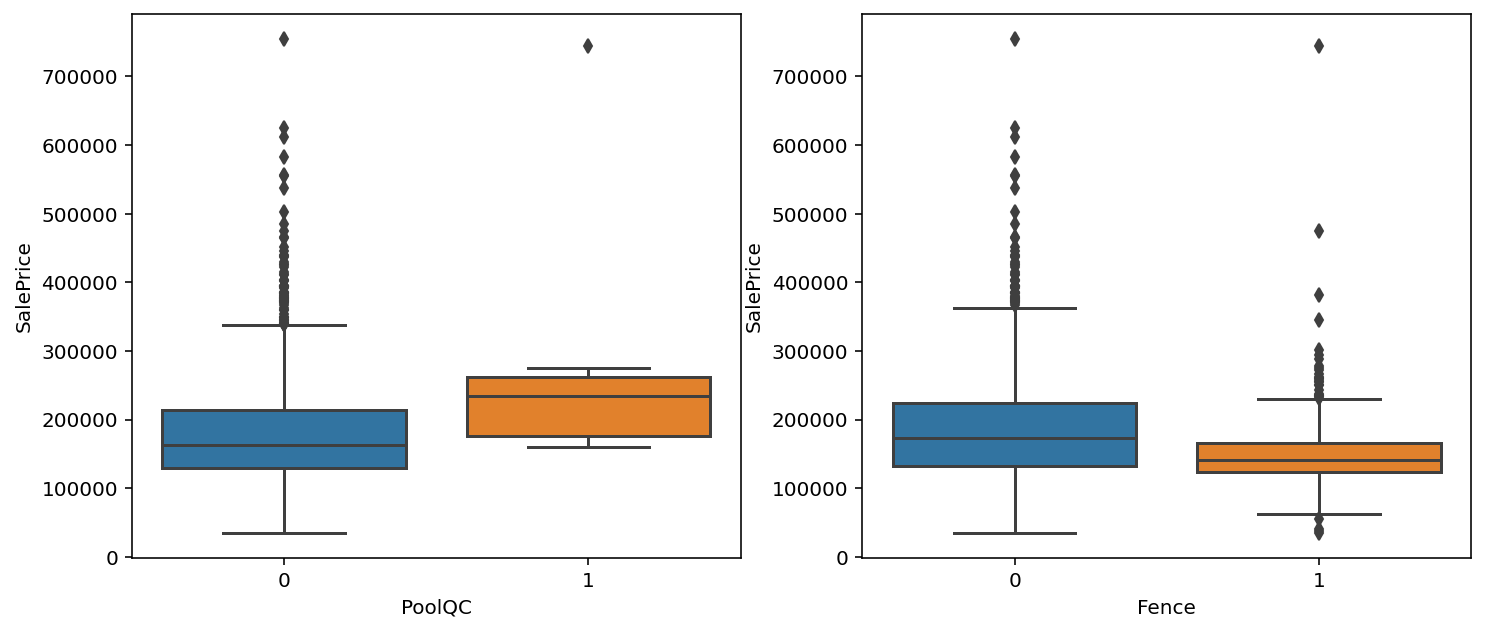

In [15]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
sns.boxplot(x=X["PoolQC"], y=y)
fig.add_subplot(122)
sns.boxplot(x=X["Fence"], y=y)

## 4. training/validation split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=101)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape)

(1314, 265) (146, 265) (1459, 265)


## 5. Modeling
- Linear Regression
    - [Ridge Regression (L2)](#Ridge-Regression)
    - [Lasso Regression (L1)](#Lasso-Regression)
- [XGBoost](#XGBoost)
- [LightGBM](#LightGBM)

### Ridge Regression

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [20]:
alpha_L2 = [15, 20, 30, 35, 40, 45, 50, 55]
parameters = {'alpha':alpha_L2, 'solver':('svd', 'saga')}
clf = GridSearchCV(Ridge(random_state=101), parameters)
clf.fit(X_train.select_dtypes(np.number), y_train)

GridSearchCV(estimator=Ridge(random_state=101),
             param_grid={'alpha': [15, 20, 30, 35, 40, 45, 50, 55],
                         'solver': ('svd', 'saga')})

In [21]:
clf.best_params_

{'alpha': 40, 'solver': 'svd'}

In [22]:
print(f'train score: {clf.best_score_}')
print(f'validation score: {clf.score(X_val, y_val)}')

train score: 0.8062876829851326
validation score: 0.897414518544719


In [23]:
y_pred_ridge = clf.predict(X_test)

sub_1 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_ridge)], axis=1).rename(columns={0:"SalePrice"})
sub_1.head()

,Id,SalePrice
0,1461,105141.152601
1,1462,140809.496253
2,1463,175925.495328
3,1464,192159.949314
4,1465,185169.689092


In [24]:
# sub_1.to_csv("submission_Ridge.csv", index=False)

### Lasso Regression

In [25]:
from sklearn.linear_model import Lasso

In [26]:
alpha_L1 = [200, 220, 250, 280, 300]
parameters = {'alpha':alpha_L1}
clf = GridSearchCV(Lasso(random_state=101), parameters)
clf.fit(X_train.select_dtypes(np.number), y_train)

GridSearchCV(estimator=Lasso(random_state=101),
             param_grid={'alpha': [200, 220, 250, 280, 300]})

In [27]:
clf.best_params_

{'alpha': 220}

In [28]:
print(f'train score: {clf.best_score_}')
print(f'validation score: {clf.score(X_val, y_val)}')

train score: 0.8147664621417988
validation score: 0.8995104905008066


In [29]:
y_pred_lasso = clf.predict(X_test)

sub_2 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_lasso)], axis=1).rename(columns={0:"SalePrice"})
sub_2.head()

,Id,SalePrice
0,1461,111286.683906
1,1462,146022.906083
2,1463,178291.735896
3,1464,191521.835004
4,1465,185872.553805


In [30]:
# sub_2.to_csv("submission_Lasso.csv", index=False)

### XGBoost

In [31]:
from xgboost import XGBRegressor

In [32]:
xgboost = XGBRegressor(learning_rate=0.005,n_estimators=4500,
                                     max_depth=5, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.005)

In [33]:
xgboost.fit(X_train, y_train)

[13:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=4500, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=27, reg_alpha=0.005,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
print(f'train score: {xgboost.score(X_train, y_train)}')
print(f'validation score: {xgboost.score(X_val, y_val)}')

train score: 0.9973915601904317
validation score: 0.9135073993151446


In [35]:
y_pred_xgboost = xgboost.predict(X_test)

sub_3 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_xgboost)], axis=1).rename(columns={0:"SalePrice"})
sub_3.head()

,Id,SalePrice
0,1461,124098.960938
1,1462,161746.375000
2,1463,185143.468750
3,1464,192409.093750
4,1465,183518.328125


In [36]:
# sub_3.to_csv("submission_XGBoost.csv", index=False)

### -- optional XGBoost with gridsearch (find best parameters)

In [37]:
# parameters = {'learning_rate': [0.005], 'n_estimators':[4500], 'max_depth':[5], 'reg_alpha':[0.005]}
# clf = GridSearchCV(XGBRegressor(min_child_weight=0, gamma=0, 
#                                         colsample_bytree=0.7, objective='reg:linear', nthread=-1,
#                                         scale_pos_weight=1, subsample=.7, seed=27), parameters)
# clf.fit(X_train.select_dtypes(np.number), y_train)

In [38]:
# clf.best_params_

# # {'learning_rate': 0.005,
# #  'max_depth': 5,
# #  'n_estimators': 4500,
# #  'reg_alpha': 0.005}

In [39]:
# print(f'train score: {clf.best_score_}')
# print(f'validation score: {clf.score(X_val, y_val)}')

# # train score: 0.8856452700799474
# # validation score: 0.9125119162731631

In [40]:
# y_pred = clf.predict(X_test)

# sub_3 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
# sub_3.head()

In [41]:
# sub_3.to_csv("submission_XGBoost_Optimized.csv", index=False)

### LightGBM

In [42]:
from lightgbm import LGBMRegressor

In [43]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=5,
                                       learning_rate=0.01, 
                                       n_estimators=5500,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [44]:
lightgbm.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.2, feature_fraction_seed=7, learning_rate=0.01,
              max_bin=200, n_estimators=5500, num_leaves=5,
              objective='regression', verbose=-1)

In [45]:
print(f'train score: {lightgbm.score(X_train, y_train)}')
print(f'validation score: {lightgbm.score(X_val, y_val)}')

train score: 0.9759014584863408
validation score: 0.9032108437904672


In [46]:
y_pred_lgbm = lightgbm.predict(X_test)

sub_4 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_lgbm)], axis=1).rename(columns={0:"SalePrice"})
sub_4.head()

,Id,SalePrice
0,1461,117881.798816
1,1462,161426.021823
2,1463,185630.402202
3,1464,194582.971932
4,1465,186312.625286


In [47]:
# sub_4.to_csv("submission_LightGBM.csv", index=False)

### -- optional LightGBM with gridsearch (find best parameters)

In [48]:
# parameters = {'learning_rate': [0.01], 'n_estimators':[5500, 6000, 7500], 'num_leaves':[3, 4, 5]}
# clf = GridSearchCV(LGBMRegressor(objective='regression', 
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,), parameters)
# clf.fit(X_train.select_dtypes(np.number), y_train)

In [49]:
# clf.best_params_

# #{'learning_rate': 0.01, 'n_estimators': 5500, 'num_leaves': 5}

In [50]:
# print(f'train score: {clf.best_score_}')
# print(f'validation score: {clf.score(X_val, y_val)}')

# #train score: 0.8856209897695116
# # validation score: 0.9069389402737372

In [51]:
# y_pred = clf.predict(X_test)

# sub_5 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred)], axis=1).rename(columns={0:"SalePrice"})
# sub_5.head()

In [52]:
# sub_5.to_csv("submission_LightGBM_Optimized.csv", index=False)

## Stacked Regressor (Merge the models together)

In [53]:
mul_lgbm = 0.30
mul_xgboost = 0.47
mul_ridge = 0.03
mul_lasso = 0.2
print(mul_lgbm + mul_xgboost + mul_ridge + mul_lasso)

1.0


In [54]:
y_pred_final_1 = (y_pred_lgbm * mul_lgbm) + (y_pred_xgboost * mul_xgboost) + (y_pred_ridge * mul_ridge) + (y_pred_lasso * mul_lasso)

sub_6 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_final_1)], axis=1).rename(columns={0:"SalePrice"})
sub_6.tail()

,Id,SalePrice
1454,2915,83136.152550
1455,2916,76392.588665
1456,2917,169001.765341
1457,2918,119416.760491
1458,2919,226354.525995


In [55]:
# sub_6.to_csv("submission_Merge_1.csv", index=False) #0.12077

## Evaluation

In [56]:
from sklearn.metrics import mean_squared_log_error

In [57]:
y_compare = pd.read_csv('./submission_0.1.csv')

In [58]:
np.sqrt(mean_squared_log_error(y_compare["SalePrice"], y_pred_final_1))

0.05458750697382005

## --optional blended regression

In [59]:
mul_lgbm = 0.15
mul_xgboost = 0.2
mul_ridge = 0.05
mul_lasso = 0.1
mul_com = 0.5
print(mul_lgbm + mul_xgboost + mul_ridge + mul_lasso + mul_com)

1.0


In [60]:
y_pred_final_2 = (y_pred_lgbm * mul_lgbm) + (y_pred_xgboost * mul_xgboost) + (y_pred_ridge * mul_ridge) + (y_pred_lasso * mul_lasso) + (y_compare["SalePrice"] * mul_com)

sub_6 = pd.concat([pd.Series(X_test.index), pd.Series(y_pred_final_2)], axis=1).rename(columns={0:"SalePrice"})
sub_6.tail()

,Id,SalePrice
1454,2915,84209.779427
1455,2916,78234.939503
1456,2917,170437.614682
1457,2918,118453.066835
1458,2919,223281.223580


In [61]:
# sub_6.to_csv("submission_Merge_blended.csv", index=False) #0.11556

In [62]:
np.sqrt(mean_squared_log_error(y_compare["SalePrice"], y_pred_final_2))

0.027388633420705858